This script explores the effect of temperature threshold exceedances on global GDP.

Key research questions we look at are 
 - What is a good model for relating GDP to metrics describing GMT? 
 - What is the marginial effect of cumulative exceedane depth & global GDP? 
 - What is the marginial effect of cumulative exceedane depth on country-level GDP? 

The goal of this script is to use the model found in 001_model_selection.ipynb to look at the marginal effect of cumulative exceedance depth on global & country-level GDP.  

In [65]:
import sys
sys.path.append('/Users/schoens/Documents/Projekte/Econ/Code/v3/')

import numpy as np
import pandas as pd 
import xarray as xr
import statsmodels.api as sm

from pathlib import Path
import config.settings as cset

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_exc^2', 'glmt_uxc^2', 'glmt_eoc^2', 'glmt_eoc'] 
with threshold of 2.0

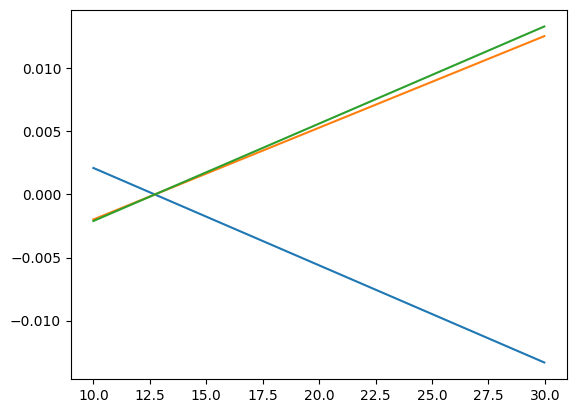

In [66]:
# load data 
regression_df  = pd.read_csv(Path.joinpath(cset.path_CHAR_results, 'regression_dataset.csv'), index_col = 0)

# combine into regression data 
# intercept matrix for country fixed effects  
n_countries    = int(len(regression_df)/1000)
X_intercept    = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1
    
    
# X_pred_hot      = np.c_[hot_df.loc[:, ['tas_soc', 'gmt_exc', 'gmt_uxc', 'gmt_eoc']].values,
#                         hot_df.loc[:, ['tas_soc']].values**2,
#                         (hot_df.loc[:, ['gmt_exc', 'gmt_uxc']].values.T*hot_df.loc[:, 'tas_baseline'].values).T
#                         ]
# def objective_function(x, *a):
#     b2    = a[2]/a[1]*a[5]
#     a_adj = np.append(a[:6], np.append([b2], a[6:]))
#     return(a_adj@x)

# ['tas_soc', 'gmt_exc', 'gmt_uxc', 'gmt_eoc', 'tas_soc', 'gmt_exc tas', 'gmt_uxc tas']

# sel_predictors = regression_df.columns.difference(['log_diff_SSP2', 'iso', 'scen_run', 'tas_baseline'])
sel_predictors = ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc']
# sel_predictors = ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'glmt_eoc', 'glmt_eoc^2', 'tas_soc', 'tas_soc^2']
X              = np.c_[regression_df[sel_predictors], X_intercept]
y              = regression_df['log_diff_SSP2'].values  

country_model  = sm.OLS(endog = y, exog = X).fit()

def objective_function(x, *a):
    b2    = a[2]/a[0]*a[1]
    a_adj = np.append(a[:3], np.append([b2], a[3:]))
    return(a_adj@x)

from scipy.optimize import curve_fit

popt, pcov = curve_fit(objective_function, 
                       X.T,
                       y,
                       p0 = np.append(country_model.params[:3], 
                                      country_model.params[4:]))

results_country_params = np.append(popt[:3], np.append([popt[2]/popt[0]*popt[1]], popt[3:]))
country_model.params = results_country_params

sel_global_predictors = [predictor for predictor in sel_predictors if not 'tas_baseline' in predictor]
X_global              = np.c_[regression_df[sel_global_predictors], X_intercept]
y                     = regression_df['log_diff_SSP2'].values  

global_model   = sm.OLS(endog = y, exog = X_global).fit()

x_Ts    = np.arange(10,30,0.025)
plt.figure()
plt.plot(x_Ts, country_model.params[0] + x_Ts*country_model.params[1])
plt.plot(x_Ts, country_model.params[2] + x_Ts*country_model.params[3])
plt.plot(x_Ts, -(country_model.params[0] + x_Ts*country_model.params[1]))
# plt.plot(x_Ts, -(country_model.params[0] + x_Ts*country_model.params[1]))
plt.show()



In [4]:
# # load data 
# regression_df  = pd.read_csv(Path.joinpath(cset.path_CHAR_results, 'regression_dataset.csv'), index_col = 0)

# # combine into regression data 
# # intercept matrix for country fixed effects  
# n_countries    = int(len(regression_df)/1000)
# X_intercept    = np.zeros((len(regression_df), n_countries))
# for i in range(n_countries):
#     X_intercept[i*1000:(i+1)*1000, i] = 1

# # sel_predictors = regression_df.columns.difference(['log_diff_SSP2', 'iso', 'scen_run', 'tas_baseline'])
# sel_predictors = ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc','glmt_uxc tas_baseline',  'tas_soc', 'tas_soc^2']
# X              = np.c_[regression_df[sel_predictors], X_intercept]
# y              = regression_df['log_diff_SSP2'].values  

# # fit model 
# country_model  = sm.OLS(endog = y, exog = X).fit()

# sel_global_predictors = [predictor for predictor in sel_predictors if not 'tas_baseline' in predictor]
# X_global              = np.c_[regression_df[sel_global_predictors], X_intercept]
# y                     = regression_df['log_diff_SSP2'].values  

# global_model   = sm.OLS(endog = y, exog = X_global).fit()

# # model.summary()

In [62]:
import numpy as np
import matplotlib
from matplotlib import colormaps as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.collections import LineCollection

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [43]:
# new zealand (NZL) is pretty much zero 
focus_countries         = ['IND', 'USA', 'CHN', 'BRA', 'FRA', 'NGA']
focus_countries_names   = ['India', 'USA', 'China', 'Brazil', 'France', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
focus_colours           = ['lightpink', 'blueviolet', 'gold', 'magenta', 'dodgerblue', 'skyblue'] 
focus_linestyles        = [(0, (1,1)), (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (5,5)), 'solid'] 

In [8]:
orig_cmap    = cm.get_cmap('RdBu_r')
# zero change at 12.44°C --> scale colormap such that it is centered around 12.44
shifted_cmap = shiftedColorMap(orig_cmap, start=0, midpoint = 0.1124, stop = 1, name='RdBu_r_shiftedv0')

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_84223/1472951007.py:55: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=newcmap)


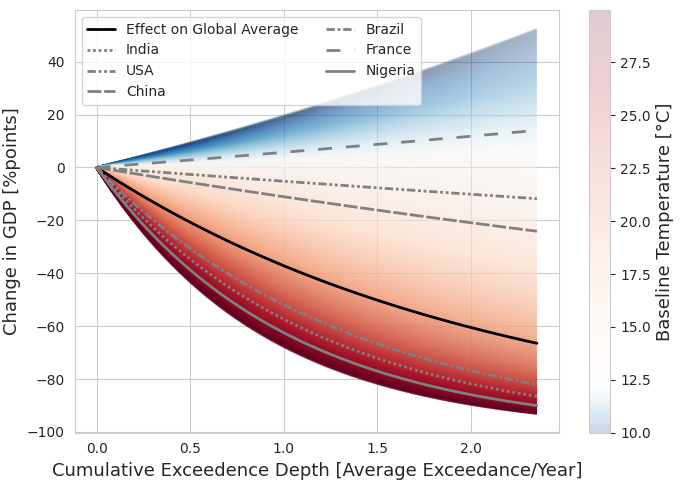

In [67]:
country_params = country_model.params

n_steps  = 100
x_exc   = np.linspace(0, 200, n_steps)

with sns.axes_style('whitegrid'):
    x_Ts    = np.arange(10,30,0.025)
    n_lines = len(x_Ts)
    y_synth = np.array([country_params[0]*x_exc + country_params[1]*x_exc*x_T for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    fig, ax = plt.subplots(figsize = (7,5))
    lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap='RdBu_r_shiftedv0', lw=2, alpha = .2)

    axcb = fig.colorbar(lc)
    
    y_synth = global_model.params[0]*x_exc
    plt.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = f'Effect on Global Average', color = 'black', linewidth = 2)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = country_params[0]*x_exc +  country_params[1]*x_exc*country_temp
        plt.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = country_name, color = 'grey', linewidth = 2,  linestyle = focus_linestyles[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = '13')
    ax.legend(loc  = 'upper left', ncols = 2)
    ax.set_xlabel('Cumulative Exceedence Depth [Average Exceedance/Year]', fontsize = '13')
    ax.set_ylabel('Change in GDP [%points]', fontsize = '13')
    plt.tight_layout()

### Temperature vs. Impact Reversibility

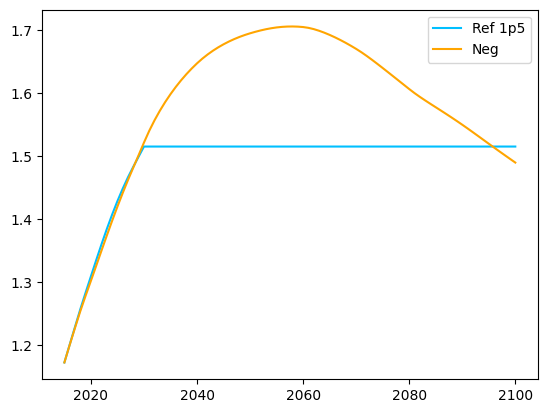

In [45]:
# take Ref1p5 and Neg as examples: 
scenarios = ['Ref1p5', 'Neg']
# scenarios = ['ssp119', 'SP', 'GS', 'ssp534-over', 'CurPol']

list_gmt_mean = []
for i_scen in range(len(scenarios)):
    scenario = scenarios[i_scen]
    gmt_mean = pd.read_csv(Path.joinpath(cset.path_FAIR, f'scen_{scenario}.csv'), index_col = 0).mean(axis = 1).loc[slice(2015,2100)].values
    list_gmt_mean.append(gmt_mean)

plt.figure()
plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[0], color = '#00BFFF', label = 'Ref 1p5')
plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[1], color = '#FFA500', label = 'Neg')
plt.legend()
plt.show()

In [56]:
# smoothing pathways to make changes look less sudden 
# import pandas as pd
# def rollavg_pandas(a,n):
#     'Pandas rolling average'
#     return pd.DataFrame(a).rolling(n, center=False, min_periods=5).mean().to_numpy()[:, 0]


# gmt_ref_smooth = rollavg_pandas(list_gmt_mean[0],5)
# gmt_neg_smooth = rollavg_pandas(list_gmt_mean[1],5)

# plt.figure()
# plt.plot(gmt_ref_smooth, color = '#00BFFF', label = 'Ref 1p5')
# plt.plot(gmt_neg_smooth, color = '#FFA500', label = 'Neg')
# plt.legend()
# plt.show()

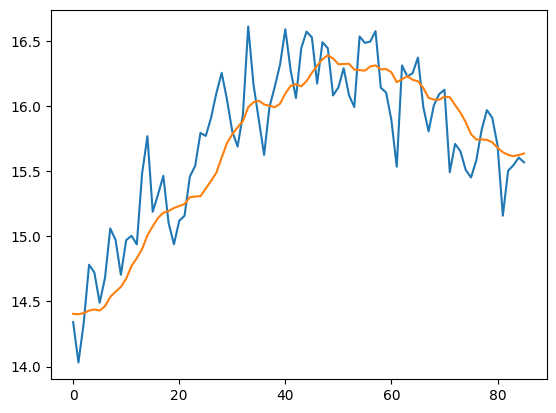

In [13]:
import pandas as pd
def rollavg_pandas(a,n):
    'Pandas rolling average'
    return pd.DataFrame(a).rolling(n, center=False, min_periods=5).mean().to_numpy()[:, 0]

n_scenarios = 10
scenarios   = cset.scenarios
gmt_smooth  = np.zeros((n_scenarios, 86, 100))
gmt_full    = np.zeros((n_scenarios, 86, 100))
for i_scen in range(len(scenarios)): 
    scenario = scenarios[i_scen]
    gmt_realisations_tmp     = xr.load_dataset(Path.joinpath(cset.path_MESMER_fldmean, f'{scenario}_fldmean.nc'))['tas'].values[:, :].T
    gmt_realisations_smooth  = np.array([rollavg_pandas(gmt_realisations_tmp[:, i], 10) for i in range(100)]).T
    gmt_smooth[i_scen, :, :] = gmt_realisations_smooth[-86:, :]
    gmt_full[i_scen, :, :]   = gmt_realisations_tmp[-86:, :]
gmt_smooth = np.moveaxis(gmt_smooth, [0,1,2], [0,2,1]).reshape(-1, 86)
gmt_full   = np.moveaxis(gmt_full, [0,1,2], [0,2,1]).reshape(-1, 86)
plt.figure()
plt.plot(gmt_full[705,:])
plt.plot(gmt_smooth[705,:])
plt.show()

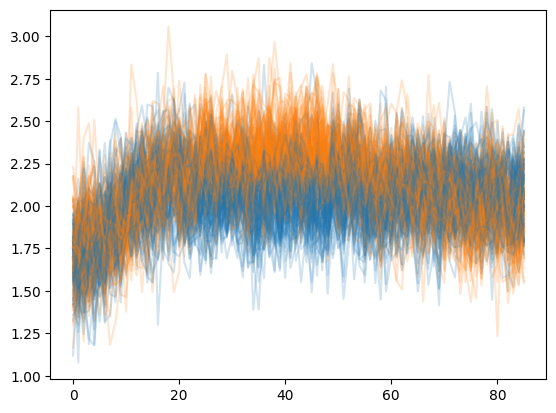

In [46]:
glmt       = np.zeros((cset.n_scenarios*100, cset.n_years))
columns    = []
ref_values = []
for i_scen in range(cset.n_scenarios): 
    scenario = cset.scenarios[i_scen]
    glmt_tmp = xr.load_dataset(Path.joinpath(cset.path_MESMER_fldmean, f"{scenario}_fldmean.nc"))['tas'].values
    ref_values.append(glmt_tmp[:, :50].mean())
    glmt[i_scen*100:(i_scen+1)*100, :] = glmt_tmp[:, -86:]
    columns.append([scenario + f'_{int(i_run+1)}' for i_run in range(100)])
glmt    = glmt - np.mean(ref_values)
columns = np.array(columns).flatten()

plt.figure()
for i in range(100):
    gmt_ref     = glmt[500:600,:].mean(axis = 0)  + (gmt_full[500+i,:] - gmt_smooth[500+i,:])
    gmt_neg     = glmt[200:300,:].mean(axis = 0)  + (gmt_full[200+i,:] - gmt_smooth[200+i,:])
    plt.plot(gmt_ref, color = 'C0', alpha = .2)
    plt.plot(gmt_neg, color = 'C1', alpha = .2)
plt.show()

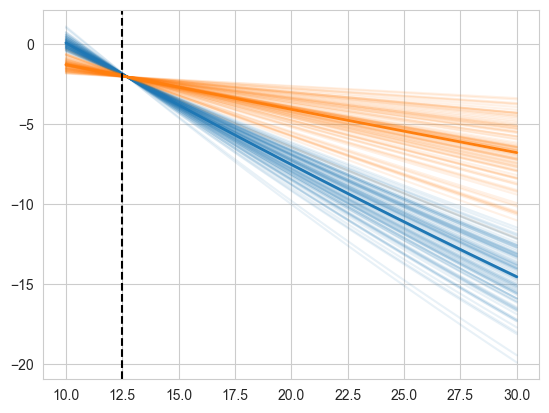

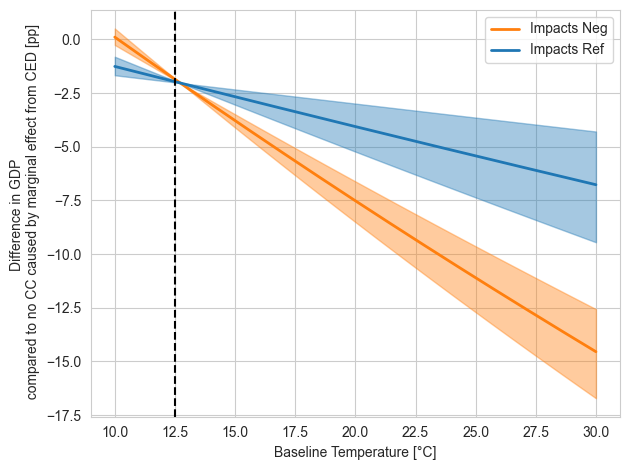

In [69]:
thrshld = 2.00

impact_matrix_neg = []
impact_matrix_ref = []

x_Ts        = np.arange(10,30.05,0.05)

for i in range(100): 
    # gmt_ref     = glmt[500:600,:].mean(axis = 0)  + (gmt_full[500+i,:] - gmt_smooth[500+i,:])
    gmt_ref     = glmt[500:600,:].mean(axis = 0)  + (gmt_full[500+i,:] - gmt_smooth[500+i,:])
    gmt_neg     = glmt[200:300,:].mean(axis = 0)  + (gmt_full[200+i,:] - gmt_smooth[200+i,:])

    # thrshld = 1.79

    # compute metrics 
    glmt_ref_exc = (gmt_ref[gmt_ref>thrshld]-thrshld).sum()
    glmt_ref_uxc = -(gmt_ref[gmt_ref<thrshld]-thrshld).sum()
    glmt_ref_soc = gmt_ref[0]

    glmt_neg_exc = (gmt_neg[gmt_neg>thrshld]-thrshld).sum()
    glmt_neg_uxc = -(gmt_neg[gmt_neg<thrshld]-thrshld).sum()
    glmt_neg_soc = gmt_neg[0]
    
    glmt_eoc     = 2.0
    
    # impact_matrix_neg.append(-(1-np.exp(glmt_neg_exc*country_model.params[0]+glmt_neg_exc*x_Ts*country_model.params[1]+glmt_neg_uxc*country_model.params[2]+glmt_neg_uxc*x_Ts*country_model.params[3]+glmt_eoc*country_model.params[6]+glmt_eoc**2*country_model.params[7]+glmt_neg_exc**2*country_model.params[8]+glmt_neg_soc*country_model.params[9]+glmt_neg_soc*x_Ts*country_model.params[10]))*100)
    # impact_matrix_ref.append(-(1-np.exp(glmt_ref_exc*country_model.params[0]+glmt_ref_exc*x_Ts*country_model.params[1]+glmt_ref_uxc*country_model.params[2]+glmt_ref_uxc*x_Ts*country_model.params[3]+glmt_eoc*country_model.params[6]+glmt_eoc**2*country_model.params[7]+glmt_ref_exc**2*country_model.params[8]+glmt_ref_soc*country_model.params[9]+glmt_ref_soc*x_Ts*country_model.params[10]))*100)
    impact_matrix_neg.append(-(1-np.exp(glmt_neg_exc*country_model.params[0]+glmt_neg_exc*x_Ts*country_model.params[1]+glmt_neg_uxc*country_model.params[2]+glmt_neg_uxc*x_Ts*country_model.params[3]+glmt_eoc*country_model.params[6]))*100)
    impact_matrix_ref.append(-(1-np.exp(glmt_ref_exc*country_model.params[0]+glmt_ref_exc*x_Ts*country_model.params[1]+glmt_ref_uxc*country_model.params[2]+glmt_ref_uxc*x_Ts*country_model.params[3]+glmt_eoc*country_model.params[6]))*100)

    # impact_matrix_neg.append(-(1-np.exp(glmt_neg_exc*country_model.params[0]+glmt_neg_exc*x_Ts*country_model.params[1]+glmt_neg_uxc*country_model.params[2]+glmt_neg_uxc*x_Ts*country_model.params[3]+glmt_eoc*country_model.params[6]+glmt_eoc**2*country_model.params[7]+glmt_neg_exc**2*country_model.params[8]))*100)
    # impact_matrix_ref.append(-(1-np.exp(glmt_ref_exc*country_model.params[0]+glmt_ref_exc*x_Ts*country_model.params[1]+glmt_ref_uxc*country_model.params[2]+glmt_ref_uxc*x_Ts*country_model.params[3]+glmt_eoc*country_model.params[6]+glmt_eoc**2*country_model.params[7]+glmt_ref_exc**2*country_model.params[8]))*100)

    # impact_matrix_neg.append(-(1-np.exp(glmt_neg_exc*country_model.params[0]+glmt_neg_exc*x_Ts*country_model.params[1]+glmt_neg_uxc*country_model.params[2]+glmt_neg_uxc*x_Ts*country_model.params[3]))*100)
    # impact_matrix_ref.append(-(1-np.exp(glmt_ref_exc*country_model.params[0]+glmt_ref_exc*x_Ts*country_model.params[1]+glmt_ref_uxc*country_model.params[2]+glmt_ref_uxc*x_Ts*country_model.params[3]))*100)


impact_matrix_neg = np.array(impact_matrix_neg)
impact_matrix_ref = np.array(impact_matrix_ref)

with sns.axes_style('whitegrid'):
    plt.figure()
    plt.plot(x_Ts, impact_matrix_neg.T, alpha = .1, color = 'C0')
    plt.plot(x_Ts, np.mean(impact_matrix_neg.T, axis = 1), color = 'C0', linewidth = 2, label = 'Impacts Neg')
    plt.plot(x_Ts, impact_matrix_ref.T, alpha = .1, color = 'C1')
    plt.plot(x_Ts, np.mean(impact_matrix_ref.T, axis = 1), color = 'C1', linewidth = 2, label = 'Impacts Ref')
    plt.axvline(12.5, color = 'black', linestyle = '--')
    plt.show()
    
with sns.axes_style('whitegrid'):
    plt.figure()
    # plt.plot(x_Ts, impact_matrix_neg.T, alpha = .1, color = 'C0')
    plt.fill_between(x_Ts, np.quantile(impact_matrix_neg.T, 0.1, axis = 1), np.quantile(impact_matrix_neg.T, 0.9, axis = 1), color = 'C1', alpha = .4)
    plt.plot(x_Ts, np.mean(impact_matrix_neg.T, axis = 1), color = 'C1', linewidth = 2, label = 'Impacts Neg')
    plt.fill_between(x_Ts, np.quantile(impact_matrix_ref.T, 0.1, axis = 1), np.quantile(impact_matrix_ref.T, 0.9, axis = 1), color = 'C0', alpha = .4)
    plt.plot(x_Ts, np.mean(impact_matrix_ref.T, axis = 1), color = 'C0', linewidth = 2, label = 'Impacts Ref')
    plt.axvline(12.5, color = 'black', linestyle = '--')
    plt.xlabel('Baseline Temperature [°C]')
    plt.ylabel('Difference in GDP \n compared to no CC caused by marginal effect from CED [pp]')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [19]:
# impact_matrix_neg = []
# impact_matrix_ref = []

# x_Ts        = np.arange(10,30.05,0.05)

# for i in range(100): 
#     gmt_ref     = glmt[500:600,:].mean(axis = 0)  + (gmt_full[500+i,:] - gmt_smooth[500+i,:])
#     gmt_neg     = glmt[200:300,:].mean(axis = 0)  + (gmt_full[200+i,:] - gmt_smooth[200+i,:])

#     # compute metrics 
#     glmt_ref_exc = (gmt_ref[gmt_ref>thrshld]-thrshld).sum()
#     glmt_ref_uxc = -(gmt_ref[gmt_ref<thrshld]-thrshld).sum()

#     glmt_neg_exc = (gmt_neg[gmt_neg>thrshld]-thrshld).sum()
#     glmt_neg_uxc = -(gmt_neg[gmt_neg<thrshld]-thrshld).sum()
    
#     impact_matrix_neg.append(-(1-np.exp(glmt_neg_exc*country_model.params[0]+glmt_neg_exc*x_Ts*country_model.params[1]+glmt_neg_uxc*country_model.params[2]+glmt_neg_uxc*x_Ts*country_model.params[3]))*100)
#     impact_matrix_ref.append(-(1-np.exp(glmt_ref_exc*country_model.params[0]+glmt_ref_exc*x_Ts*country_model.params[1]+glmt_ref_uxc*country_model.params[2]+glmt_ref_uxc*x_Ts*country_model.params[3]))*100)

# impact_matrix_neg = np.array(impact_matrix_neg)
# impact_matrix_ref = np.array(impact_matrix_ref)

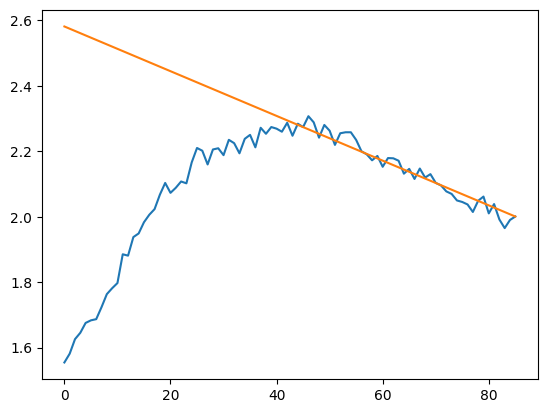

15.682387147033737 2.0919326836810583


In [48]:
x         = np.linspace(2015, 2100, 86)
p         = np.polyfit([2060, 2100], [glmt[200:300,:].mean(axis = 0)[45], glmt[200:300,:].mean(axis = 0)[-1]], 1)
y_lin_og  = p[0]*x + p[1]
plt.figure()
plt.plot(glmt[200:300,:].mean(axis = 0))
plt.plot(y_lin_og)
plt.show()
print(glmt_neg_exc, glmt_neg_uxc)

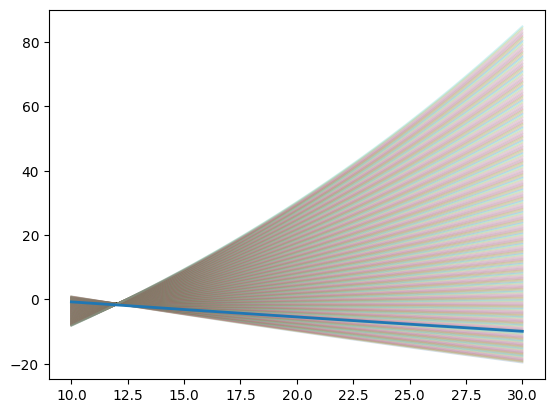

In [49]:
# construct linear function that does through 2060 - max value glmt and 2100 - some eoc value 
# test for different eoc values and construct mean trajectory 

impact_matrix_neg_adj    = []
for x_eoc in np.arange(2.1,-1,-0.01):
    impact_matrix_neg_adj_tmp = []
    
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [2.27, x_eoc], 1)
    y_lin     = p[0]*x + p[1]
    
    for i in range(100):
        gmt_neg_adj      = glmt[200:300,:].mean(axis = 0).copy()
        gmt_neg_adj[45:] += y_lin[45:] - y_lin_og[45:]
        gmt_neg_adj      += (gmt_full[200+i,:] - gmt_smooth[200+i,:])

        glmt_neg_adj_exc = (gmt_neg_adj[gmt_neg_adj>thrshld]-thrshld).sum()
        glmt_neg_adj_uxc = -(gmt_neg_adj[gmt_neg_adj<thrshld]-thrshld).sum()

        impact_matrix_neg_adj_tmp.append(-(1-np.exp(glmt_neg_adj_exc*country_model.params[0]+glmt_neg_adj_exc*x_Ts*country_model.params[1]+glmt_neg_adj_uxc*country_model.params[2]+glmt_neg_adj_uxc*x_Ts*country_model.params[3]+x_eoc*country_model.params[6]))*100)

    impact_matrix_neg_adj.append(np.mean(np.array(impact_matrix_neg_adj_tmp), axis = 0))

impact_matrix_neg_adj = np.array(impact_matrix_neg_adj)


plt.figure()
plt.plot(x_Ts, impact_matrix_neg_adj.T, alpha = .2)
plt.plot(x_Ts, np.mean(impact_matrix_ref.T, axis = 1), color = 'C0', linewidth = 2, label = 'Impacts Ref')
plt.show()

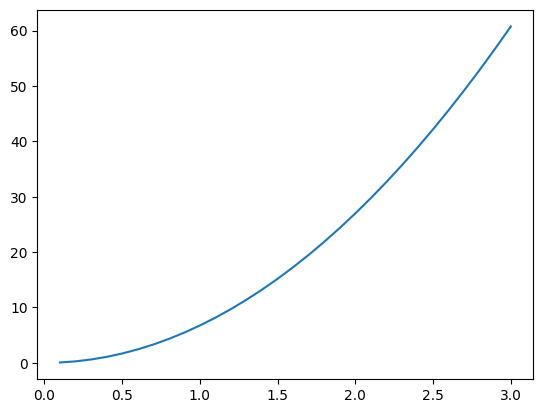

In [51]:
X_eocs = np.arange(3.0,0,-0.1)
plt.figure()
plt.plot(X_eocs, X_eocs*country_model.params[6]+X_eocs**2*country_model.params[7])
plt.show()

2.5
2.0
1.5
1.0
0.5


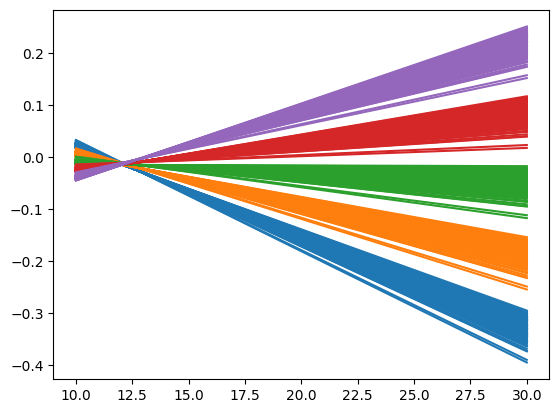

In [50]:
plt.figure()
j = 0
for x_eoc in np.arange(2.5,0,-0.5):
    print(x_eoc)
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [2.27, x_eoc], 1)
    y_lin     = p[0]*x + p[1]
    for i in range(100):
        gmt_neg_adj      = glmt[200:300,:].mean(axis = 0).copy()
        gmt_neg_adj[45:] += y_lin[45:] - y_lin_og[45:]
        gmt_neg_adj      += (gmt_full[200+i,:] - gmt_smooth[200+i,:])
        glmt_neg_adj_exc = (gmt_neg_adj[gmt_neg_adj>thrshld]-thrshld).sum()
        glmt_neg_adj_uxc = -(gmt_neg_adj[gmt_neg_adj<thrshld]-thrshld).sum()
        # impact = -(1-np.exp(glmt_neg_adj_exc*country_model.params[0]+glmt_neg_adj_exc*x_Ts*country_model.params[1]+glmt_neg_adj_uxc*country_model.params[2]+glmt_neg_adj_uxc*x_Ts*country_model.params[3]+x_eoc*country_model.params[6]+x_eoc**2*country_model.params[7]+glmt_neg_adj_exc**2*country_model.params[8]))*100
        impact = glmt_neg_adj_exc*country_model.params[0]+glmt_neg_adj_exc*x_Ts*country_model.params[1]+glmt_neg_adj_uxc*country_model.params[2]+glmt_neg_adj_uxc*x_Ts*country_model.params[3]+x_eoc*country_model.params[6]
        plt.plot(x_Ts, impact, color = f'C{j}')
    j += 1
# plt.plot(x_Ts, np.mean(impact_matrix_ref.T, axis = 1), color = f'black')
plt.show()

In [16]:
# x_eoc = np.arange(2,-1,-0.01)[34]

# x         = np.linspace(2015, 2100, 86)
# p         = np.polyfit([2060, 2100], [2.27, x_eoc], 1)
# y_lin     = p[0]*x + p[1]

# exc = []
# uxc = []

# plt.figure()
# for i in range(100):
#     gmt_neg_adj      = glmt[200:300,:].mean(axis = 0).copy()
#     gmt_neg_adj[45:] += y_lin[45:] - y_lin_og[45:]
#     gmt_neg_adj      += (gmt_full[200+i,:] - gmt_smooth[200+i,:])
#     plt.plot(gmt_neg_adj)
#     glmt_neg_adj_exc = (gmt_neg_adj[gmt_neg_adj>thrshld]-thrshld).sum()
#     glmt_neg_adj_uxc = -(gmt_neg_adj[gmt_neg_adj<thrshld]-thrshld).sum()
#     exc.append(glmt_neg_adj_exc)
#     uxc.append(glmt_neg_adj_uxc)
# plt.show()

# plt.figure()
# plt.plot(exc, label = 'EXC')
# plt.plot(uxc, label = 'UXC')
# plt.legend()
# plt.show()

# glmt_neg_adj_exc*country_model.params[0]+glmt_neg_adj_exc*x_Ts*country_model.params[1]+glmt_neg_adj_uxc*country_model.params[2]+glmt_neg_adj_uxc*x_Ts*country_model.params[3]

# x_exc = np.mean(exc) 
# x_uxc = np.mean(uxc)
# plt.figure()
# plt.plot(x_Ts, country_model.params[0]*x_exc+ country_model.params[1]*x_Ts*x_exc)
# plt.plot(x_Ts, country_model.params[2]*x_uxc+ country_model.params[3]*x_Ts*x_uxc)
# plt.plot(x_Ts, country_model.params[0]*x_exc+ country_model.params[1]*x_Ts*x_exc + country_model.params[2]*x_uxc+ country_model.params[3]*x_Ts*x_uxc)
# plt.show()

# x_exc = np.mean(exc) 
# x_uxc = np.mean(uxc)
# plt.figure()
# # plt.plot(x_Ts, country_model.params[0]*x_exc+ country_model.params[1]*x_Ts*x_exc)
# # plt.plot(x_Ts, country_model.params[2]*x_uxc+ country_model.params[3]*x_Ts*x_uxc)
# plt.plot(x_Ts, -(1-np.exp(country_model.params[0]*x_exc+ country_model.params[1]*x_Ts*x_exc + country_model.params[2]*x_uxc+ country_model.params[3]*x_Ts*x_uxc)))
# plt.show()

# plt.figure()
# plt.plot(impact_matrix_ref.T, color = 'C1', alpha = .1)
# plt.plot(impact_matrix_neg_adj[34,:])
# plt.show()

In [83]:
# construct linear function that does through 2060 - max value glmt and 2100 - some eoc value 
# test for different eoc values and construct mean trajectory 

# impact_matrix_neg_adj    = []


# for x_eoc in np.arange(2,-1,-0.01):
#     impact_matrix_neg_adj_tmp = []
    
#     x         = np.linspace(2015, 2100, 86)
#     p         = np.polyfit([2020, 2060, 2100], [x_eoc, 2.27, x_eoc], 2)
#     y_lin     = p[0]*x**2 + p[1]*x + p[2]
    
#     for i in range(100):
#         gmt_neg_adj      = glmt[200:300,:].mean(axis = 0).copy()
#         gmt_neg_adj[45:] += y_lin[45:] - y_lin_og[45:]
#         gmt_neg_adj      += (gmt_full[200+i,:] - gmt_smooth[200+i,:])

#         glmt_neg_adj_exc = (gmt_neg_adj[gmt_neg_adj>thrshld]-thrshld).sum()
#         glmt_neg_adj_uxc = -(gmt_neg_adj[gmt_neg_adj<thrshld]-thrshld).sum()

#         impact_matrix_neg_adj_tmp.append(-(1-np.exp(glmt_neg_adj_exc*country_model.params[0]+glmt_neg_adj_exc*x_Ts*country_model.params[1]+glmt_neg_adj_uxc*country_model.params[2]+glmt_neg_adj_uxc*x_Ts*country_model.params[3]))*100)

#     impact_matrix_neg_adj.append(np.mean(np.array(impact_matrix_neg_adj_tmp), axis = 0))


# impact_matrix_neg_adj = np.array(impact_matrix_neg_adj)

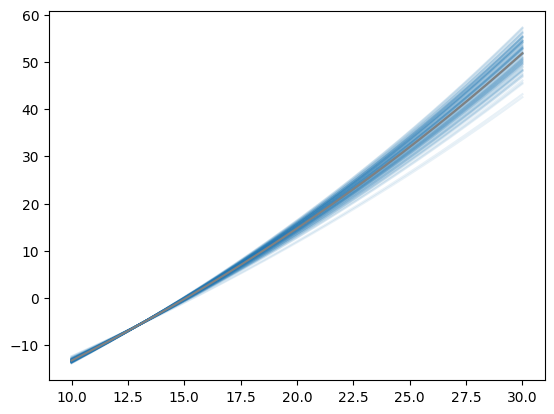

In [18]:
# x_eoc = 1.9

# impact_matrix_neg_adj_tmp = []

# x         = np.linspace(2015, 2100, 86)
# p         = np.polyfit([2060, 2100], [2.27, x_eoc], 1)
# y_lin     = p[0]*x + p[1]

# for i in range(100):
#     gmt_neg_adj      = glmt[200:300,:].mean(axis = 0).copy()
#     gmt_neg_adj[45:] += y_lin[45:] - y_lin_og[45:]
#     gmt_neg_adj      += (gmt_full[200+i,:] - gmt_smooth[200+i,:])

#     glmt_neg_adj_exc = (gmt_neg_adj[gmt_neg_adj>thrshld]-thrshld).sum()
#     glmt_neg_adj_uxc = -(gmt_neg_adj[gmt_neg_adj<thrshld]-thrshld).sum()

#     impact_matrix_neg_adj_tmp.append(-(1-np.exp(glmt_neg_adj_exc*country_model.params[0]+glmt_neg_adj_exc*x_Ts*country_model.params[1]+glmt_neg_adj_uxc*country_model.params[2]+glmt_neg_adj_uxc*x_Ts*country_model.params[3]))*100)

plt.figure()
plt.plot(x_Ts, np.array(impact_matrix_neg_adj_tmp).T, color = 'C0', alpha = .1)
plt.plot(x_Ts, np.mean(np.array(impact_matrix_neg_adj_tmp).T, axis = 1), color = 'grey')
plt.show()

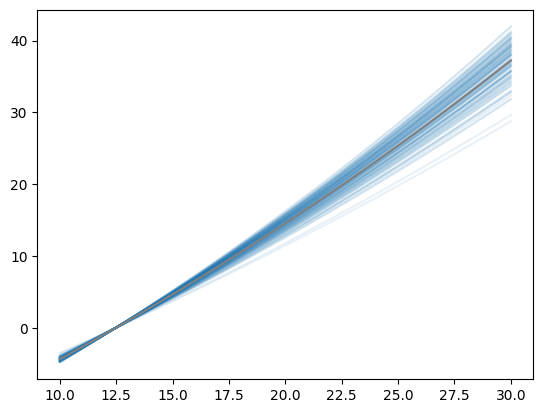

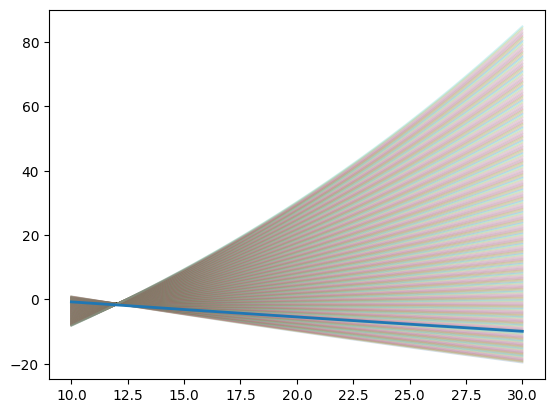

In [52]:
# finding a trajectory with similar impact as Ref, after adjusting back from overshoot 
plt.figure()
plt.plot(x_Ts, impact_matrix_neg_adj.T, alpha = .2)
plt.plot(x_Ts, np.mean(impact_matrix_ref.T, axis = 1), color = 'C0', linewidth = 2, label = 'Impacts Ref')
plt.show()

In [53]:
idx_min = np.abs(impact_matrix_neg_adj-np.mean(impact_matrix_ref.T, axis = 1)).argmin(axis = 0)

In [54]:
idx_min

array([ 53,  54,  54,  54,  55,  55,  55,  56,  56,  57,  57,  57,  58,
        59,  59,  60,  61,  61,  62,  63,  64,  65,  66,  68,  69,  71,
        73,  75,  78,  81,  84,  89,  94, 101, 109, 121, 138, 165, 212,
       309, 309,  22,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         3,   6,   9,  11,  13,  15,  17,  18,  19,  21,  22,  23,  23,
        24,  25,  26,  26,  27,  27,  28,  28,  29,  29,  30,  30,  30,
        31,  31,  31,  31,  32,  32,  32,  32,  33,  33,  33,  33,  33,
        34,  34,  34,  34,  34,  34,  35,  35,  35,  35,  35,  35,  35,
        35,  36,  36,  36,  36,  36,  36,  36,  36,  36,  36,  37,  37,
        37,  37,  37,  37,  37,  37,  37,  37,  37,  37,  37,  37,  37,
        38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,
        38,  38,  38,  38,  38,  38,  38,  38,  38,  39,  39,  39,  39,
        39,  39,  39,  39,  39,  39,  39,  39,  39,  39,  39,  39,  39,
        39,  39,  39,  39,  39,  39,  39,  39,  39,  39,  39,  3

In [24]:
gmt_trajectories_equal = []

for i in range(len(x_Ts)): 
    idx    = idx_min[i]
    x_eoc = np.arange(2.27,-1,-0.01)[idx]
    
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [2.27, x_eoc], 1)
    y_lin     = p[0]*x + p[1]

    gmt_neg_adj      = glmt[200:300,:].mean(axis = 0).copy()
    gmt_neg_adj[45:] += y_lin[45:]-y_lin_og[45:]
    
    gmt_trajectories_equal.append(gmt_neg_adj)
    
gmt_trajectories_equal = np.array(gmt_trajectories_equal)

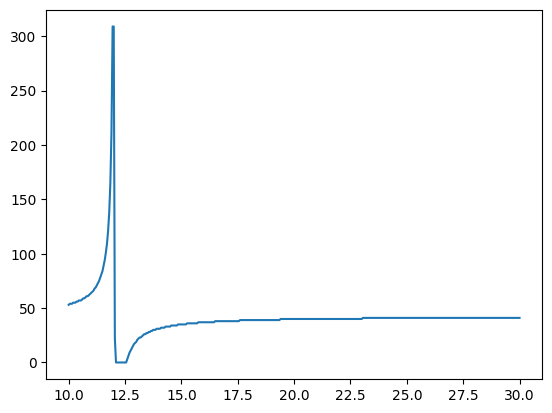

In [55]:
plt.figure()
plt.plot(x_Ts, idx_min)
plt.show()

In [56]:
gmt_trajectories_equal = []

for i in range(len(x_Ts)): 
    idx    = idx_min[i]
    x_eoc = np.arange(2.27,-1,-0.01)[idx]
    
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [ 2.27, x_eoc], 1)
    y_lin     = p[0]*x + p[1]

    gmt_neg_adj      = glmt[200:300,:].mean(axis = 0).copy()
    gmt_neg_adj[45:] += y_lin[45:]-y_lin_og[45:]
    
    gmt_trajectories_equal.append(gmt_neg_adj)
    
gmt_trajectories_equal = np.array(gmt_trajectories_equal)

In [27]:
idx_min[150:]

array([38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39,
       39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
       39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41

In [35]:
x_Ts[65:]

array([13.25, 13.3 , 13.35, 13.4 , 13.45, 13.5 , 13.55, 13.6 , 13.65,
       13.7 , 13.75, 13.8 , 13.85, 13.9 , 13.95, 14.  , 14.05, 14.1 ,
       14.15, 14.2 , 14.25, 14.3 , 14.35, 14.4 , 14.45, 14.5 , 14.55,
       14.6 , 14.65, 14.7 , 14.75, 14.8 , 14.85, 14.9 , 14.95, 15.  ,
       15.05, 15.1 , 15.15, 15.2 , 15.25, 15.3 , 15.35, 15.4 , 15.45,
       15.5 , 15.55, 15.6 , 15.65, 15.7 , 15.75, 15.8 , 15.85, 15.9 ,
       15.95, 16.  , 16.05, 16.1 , 16.15, 16.2 , 16.25, 16.3 , 16.35,
       16.4 , 16.45, 16.5 , 16.55, 16.6 , 16.65, 16.7 , 16.75, 16.8 ,
       16.85, 16.9 , 16.95, 17.  , 17.05, 17.1 , 17.15, 17.2 , 17.25,
       17.3 , 17.35, 17.4 , 17.45, 17.5 , 17.55, 17.6 , 17.65, 17.7 ,
       17.75, 17.8 , 17.85, 17.9 , 17.95, 18.  , 18.05, 18.1 , 18.15,
       18.2 , 18.25, 18.3 , 18.35, 18.4 , 18.45, 18.5 , 18.55, 18.6 ,
       18.65, 18.7 , 18.75, 18.8 , 18.85, 18.9 , 18.95, 19.  , 19.05,
       19.1 , 19.15, 19.2 , 19.25, 19.3 , 19.35, 19.4 , 19.45, 19.5 ,
       19.55, 19.6 ,

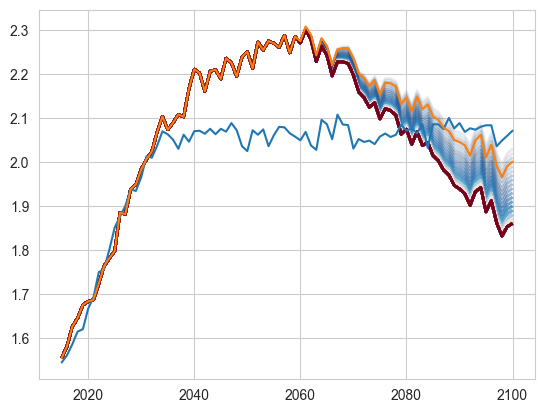

In [57]:
with sns.axes_style('whitegrid'):
    plt.figure()
    lc  = multiline(np.array([np.linspace(2015,2100,86) for i in range(401-65)]),  gmt_trajectories_equal[65:, :], x_Ts[65:], cmap='RdBu_r', lw=2, alpha =.1)
    # plt.plot(gmt_trajectories_equal.T, color = 'C1', alpha = .1)
    # plt.plot(gmt_trajectories_equal.T[:, ::50])
    plt.plot(np.linspace(2015,2100,86), glmt[500:600,:].mean(axis = 0))
    plt.plot(np.linspace(2015,2100,86), glmt[200:300,:].mean(axis = 0))
    plt.show()

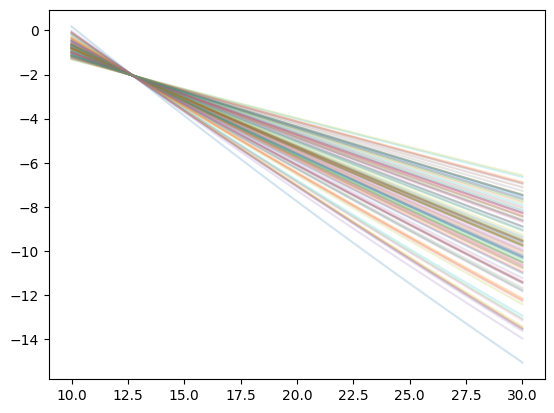

In [58]:
plt.figure()
plt.plot(x_Ts, impact_matrix_ref.T, alpha = .2)
plt.show()

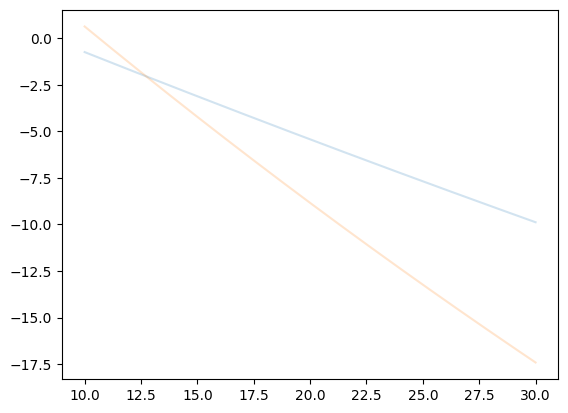

In [59]:
plt.figure()
plt.plot(x_Ts, np.mean(impact_matrix_ref, axis = 0), alpha = .2)
plt.plot(x_Ts, np.mean(impact_matrix_neg, axis = 0), alpha = .2)
plt.show()

In [95]:
x_Ts        = np.arange(10,30.05,0.05)
impacts_neg = -(1-np.exp(glmt_neg_exc*country_model.params[0]+glmt_neg_exc*x_Ts*country_model.params[1]+glmt_neg_uxc*country_model.params[2]+glmt_neg_uxc*x_Ts*country_model.params[3]))*100
impacts_ref = -(1-np.exp(glmt_ref_exc*country_model.params[0]+glmt_ref_exc*x_Ts*country_model.params[1]+glmt_ref_uxc*country_model.params[2]+glmt_ref_uxc*x_Ts*country_model.params[3]))*100


In [24]:
x_Ts        = np.arange(10,30.05,0.05)
impacts_neg = -(1-np.exp(glmt_eoc*country_model.params[0]+glmt_eoc**2*country_model.params[1]+glmt_neg_exc*country_model.params[2]+glmt_neg_exc*x_Ts*country_model.params[3]+glmt_neg_exc**2*country_model.params[4]+glmt_neg_uxc*country_model.params[5]+glmt_neg_uxc*x_Ts*country_model.params[6]))*100
impacts_ref = -(1-np.exp(glmt_eoc*country_model.params[0]+glmt_eoc**2*country_model.params[1]+glmt_ref_exc*country_model.params[2]+glmt_ref_exc*x_Ts*country_model.params[3]+glmt_ref_exc**2*country_model.params[4]+glmt_ref_uxc*country_model.params[5]+glmt_ref_uxc*x_Ts*country_model.params[6]))*100



/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_41673/1484159200.py:2: RuntimeWarning: overflow encountered in exp
  impacts_neg = -(1-np.exp(glmt_eoc*country_model.params[0]+glmt_eoc**2*country_model.params[1]+glmt_neg_exc*country_model.params[2]+glmt_neg_exc*x_Ts*country_model.params[3]+glmt_neg_exc**2*country_model.params[4]+glmt_neg_uxc*country_model.params[5]+glmt_neg_uxc*x_Ts*country_model.params[6]))*100
/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_41673/1484159200.py:3: RuntimeWarning: overflow encountered in exp
  impacts_ref = -(1-np.exp(glmt_eoc*country_model.params[0]+glmt_eoc**2*country_model.params[1]+glmt_ref_exc*country_model.params[2]+glmt_ref_exc*x_Ts*country_model.params[3]+glmt_ref_exc**2*country_model.params[4]+glmt_ref_uxc*country_model.params[5]+glmt_ref_uxc*x_Ts*country_model.params[6]))*100
/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_41673/1484159200.py:3: RuntimeWarning: overflow encountered in multiply
  impacts_ref = -

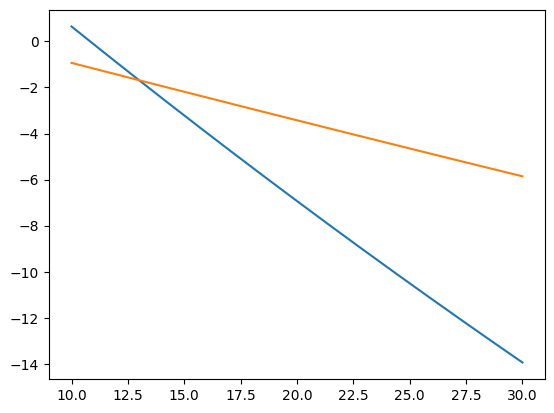

In [96]:
# add different pathways post 2060
plt.figure()
plt.plot(x_Ts, impacts_neg)
plt.plot(x_Ts, impacts_ref)
plt.show()

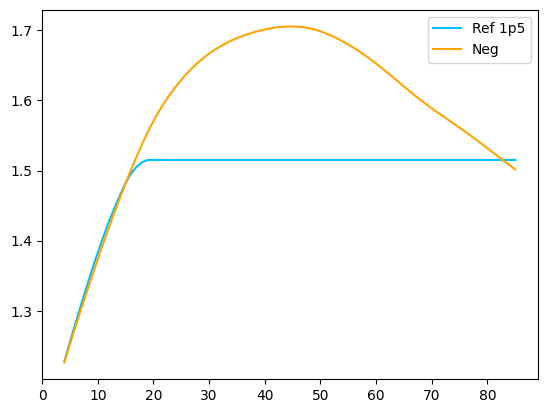

In [191]:
i_scen = 0
scenarios     = ['Ref1p5', 'Neg']
scenario      = scenarios[i_scen]
all_fair_runs = pd.read_csv(Path.joinpath(cset.path_FAIR, f'scen_{scenario}.csv'), index_col = 0)
all_fair_runs

,0,1,2,3,4,5,6,7,8,9,...,2227,2228,2229,2230,2231,2232,2233,2234,2235,2236
year,,,,,,,,,,,,,,,,,,,,,
1850,0.0125,-0.0153,0.0035,0.0768,0.0415,0.0397,0.0040,0.0204,0.0051,0.0292,...,0.0067,0.0096,-0.0040,0.0318,0.0014,-0.0136,0.0237,-0.0070,-0.0185,-0.0287
1851,0.0247,-0.0062,0.0118,0.0796,0.0496,0.0475,0.0123,0.0279,0.0141,0.0409,...,0.0163,0.0165,0.0045,0.0383,0.0123,-0.0004,0.0337,0.0029,-0.0049,-0.0118
1852,0.0343,0.0004,0.0164,0.0811,0.0555,0.0532,0.0172,0.0339,0.0204,0.0498,...,0.0235,0.0214,0.0109,0.0425,0.0208,0.0095,0.0411,0.0101,0.0056,0.0020
1853,0.0316,-0.0029,0.0062,0.0718,0.0490,0.0464,0.0085,0.0314,0.0130,0.0449,...,0.0201,0.0152,0.0083,0.0343,0.0180,0.0049,0.0361,0.0069,0.0041,0.0030
1854,0.0178,-0.0146,-0.0133,0.0531,0.0311,0.0289,-0.0097,0.0208,-0.0053,0.0274,...,0.0072,0.0004,-0.0026,0.0157,0.0055,-0.0121,0.0196,-0.0057,-0.0085,-0.0079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2296,1.6105,1.2384,1.0130,1.6487,1.5708,1.7594,1.1398,1.6465,1.3858,1.8005,...,1.4536,1.3057,1.5892,1.4876,1.4370,1.4541,1.5067,1.5234,1.4067,1.5902
2297,1.6105,1.2384,1.0130,1.6487,1.5708,1.7594,1.1398,1.6465,1.3858,1.8005,...,1.4536,1.3057,1.5892,1.4876,1.4370,1.4541,1.5067,1.5234,1.4067,1.5902
2298,1.6105,1.2384,1.0130,1.6487,1.5708,1.7594,1.1398,1.6465,1.3858,1.8005,...,1.4536,1.3057,1.5892,1.4876,1.4370,1.4541,1.5067,1.5234,1.4067,1.5902


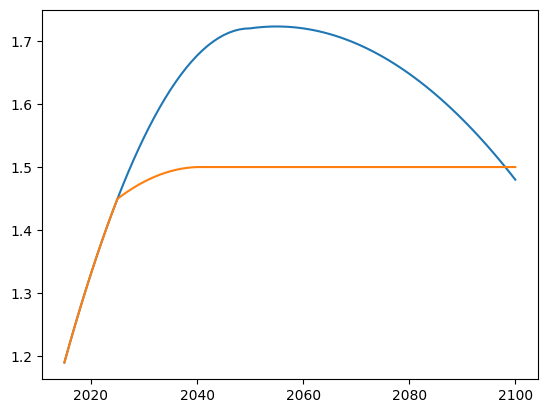

In [263]:
x_eoc = 1.5
x_os  = 1.72
x_soc = 1.2

x     = np.arange(2015,2101,1)
x_gen = (np.array([2015,2100])-2015)

# overshoot pathway: 2015 - 1.1, 2050 - 1.75, 2100 - 1.5
p1    = np.polyfit([2015, 2050, 2085], 
                    [x_soc-0.01, x_os, x_soc-0.01],
                    deg = 2)

p2    = np.polyfit([2010, 2050, 2100], 
                    [x_eoc-0.02, x_os ,x_eoc-0.02],
                    deg = 2)

gmt_3        = p1[0]*x**2+p1[1]*x+p1[2]
# gmt_3[36:40] = gmt_3[35]
gmt_3[36:]   = p2[0]*x[36:]**2+p2[1]*x[36:]+p2[2]

# ref pathway: 
p1    = np.polyfit([2025, 2030, 2040], 
                    [gmt_3[10], gmt_3[10]+0.027, x_eoc],
                    deg = 2)

gmt_2        = gmt_3.copy()
gmt_2[10:26] = p1[0]*x[10:26]**2+p1[1]*x[10:26]+p1[2]
gmt_2[26:]   = gmt_2[25]


plt.figure()
# plt.plot(x, gmt_2)
plt.plot(x, gmt_3)
plt.plot(x, gmt_2)
plt.show()

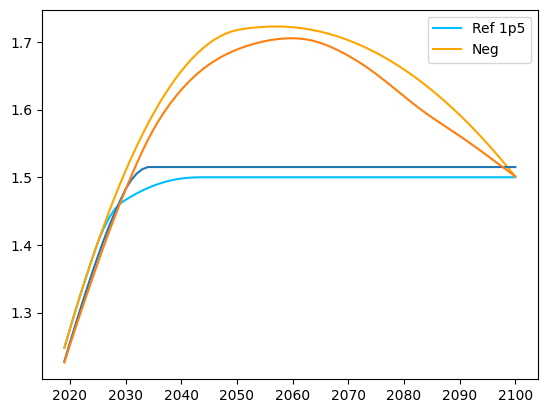

In [264]:
import pandas as pd
def rollavg_pandas(a,n):
    'Pandas rolling average'
    return pd.DataFrame(a).rolling(n, center=False, min_periods=5).mean().to_numpy()[:, 0]


gmt_2_smooth = rollavg_pandas(gmt_2,5)
gmt_3_smooth = rollavg_pandas(gmt_3,5)

plt.figure()
plt.plot(x, gmt_2_smooth, color = '#00BFFF', label = 'Ref 1p5')
plt.plot(x, gmt_3_smooth, color = '#FFA500', label = 'Neg')
plt.plot(x, gmt_ref_smooth)
plt.plot(x, gmt_neg_smooth)
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(x, gmt_2_smooth, color = '#00BFFF', label = 'Ref 1p5')
plt.plot(x, gmt_3_smooth, color = '#FFA500', label = 'Neg')
plt.legend()
plt.show()

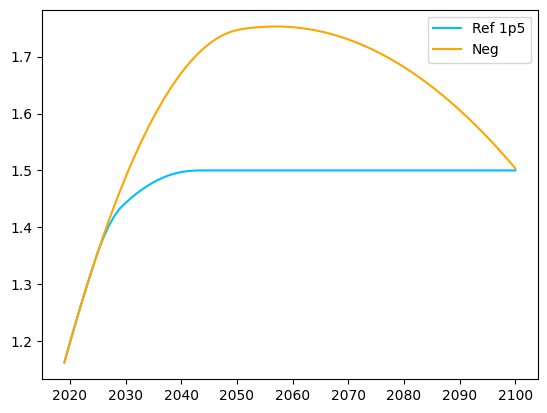

In [247]:
plt.figure()
plt.plot(x, gmt_2_smooth, color = '#00BFFF', label = 'Ref 1p5')
plt.plot(x, gmt_3_smooth, color = '#FFA500', label = 'Neg')
plt.legend()
plt.show()

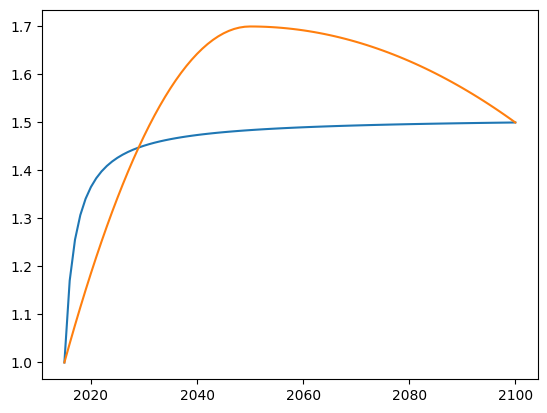

In [205]:
# constructing pathways 

# trajectory without peak and decline: 
x_eoc = 1.5
x_os  = 1.75
scale = 0.5

### ref 
x     = np.arange(2015,2101,1)
x_gen = (np.array([2015,2100])-2015)
p     = np.polyfit(x_gen*scale/(1+x_gen*scale), 
                    [1,x_eoc],
                    deg = 1)
gmt_2 = p[0]*(x-2015)*scale/(scale*(x-2015)+1)+p[1]

### overshoot
p1    = np.polyfit([2015,2050,2085], 
                    [1,x_os,1],
                    deg = 2)
p2    = np.polyfit([2000,2050,2100], 
                    [x_eoc,x_os,x_eoc],
                    deg = 2)

gmt_3      = p1[0]*x**2+p1[1]*x+p1[2]
gmt_3[35:] = p2[0]*x[35:]**2+p2[1]*x[35:]+p2[2]

plt.figure()
plt.plot(x, gmt_2)
plt.plot(x, gmt_3)
plt.show()

In [177]:
import pandas as pd
def rollavg_pandas(a,n):
    'Pandas rolling average'
    return pd.DataFrame(a).rolling(n, center=True, min_periods=1).mean().to_numpy()[:, 0]

n_scenarios = 10
scenarios   = cset.scenarios
gmt_smooth  = np.zeros((n_scenarios, 86, 100))
for i_scen in range(len(scenarios)): 
    scenario = scenarios[i_scen]
    glmt_tmp = xr.load_dataset(Path.joinpath(cset.path_MESMER_fldmean, f"{scenario}_fldmean.nc"))['tas'].values
    glmt_ref = glmt_tmp[:, :50].mean(axis = 1)
    gmt_realisations_tmp     = (glmt_tmp[:, :].T - glmt_ref)
    gmt_realisations_smooth  = np.array([rollavg_pandas(gmt_realisations_tmp[:, i], 15) for i in range(100)]).T
    gmt_smooth[i_scen, :, :] = gmt_realisations_smooth[-86:, :]
gmt_smooth = np.moveaxis(gmt_smooth, [0,1,2], [0,2,1]).reshape(-1, 86)

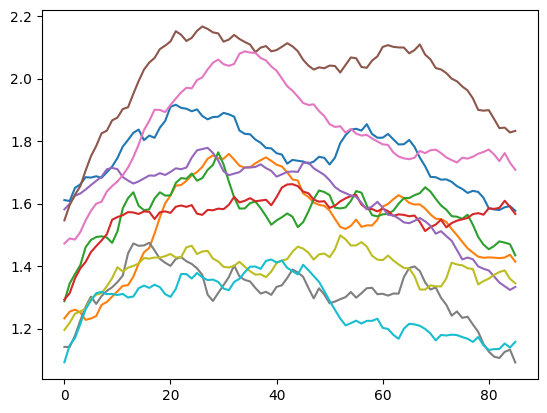

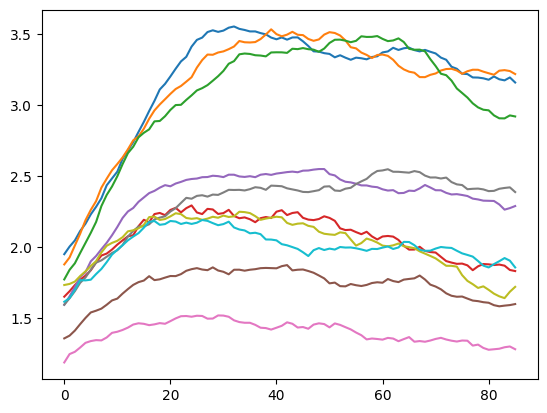

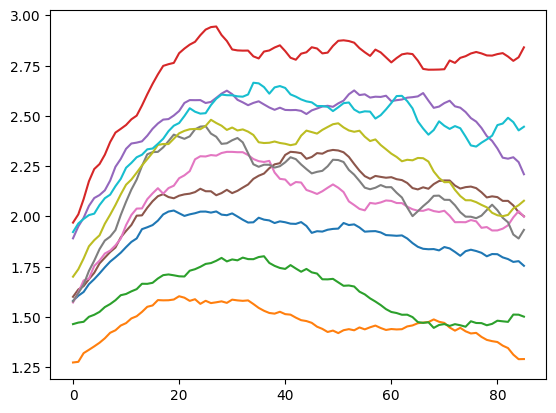

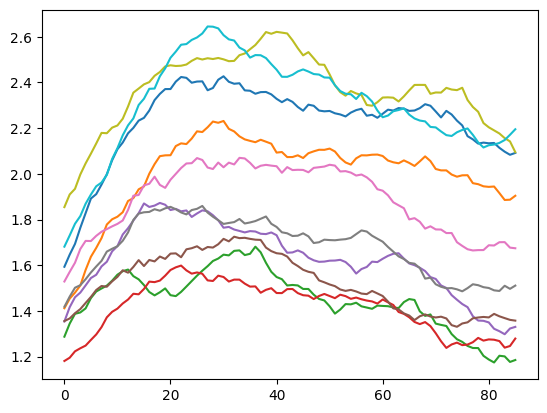

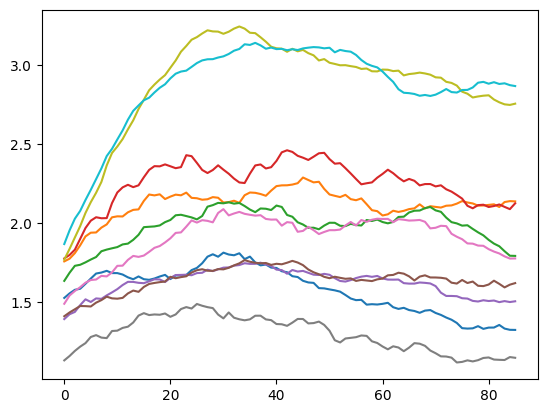

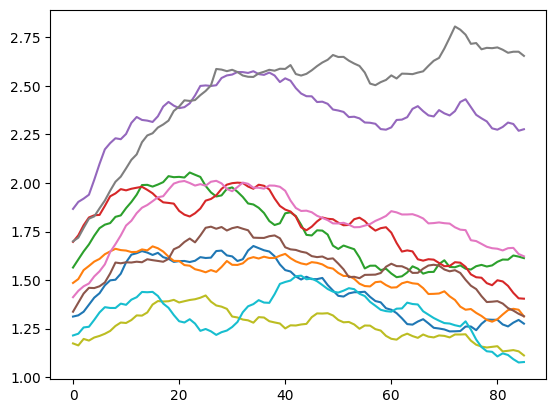

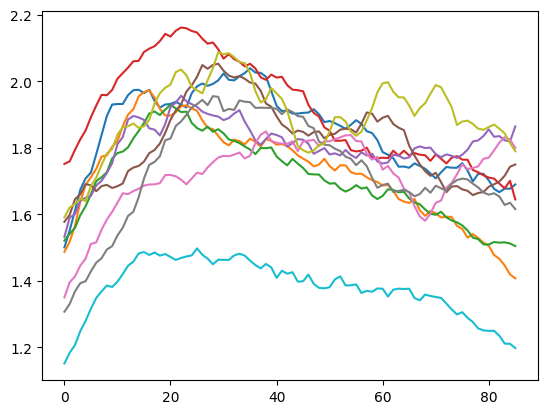

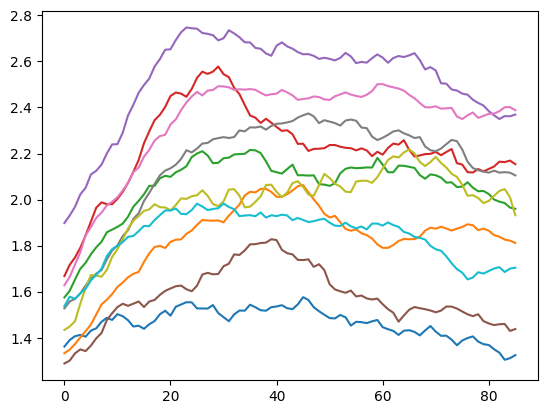

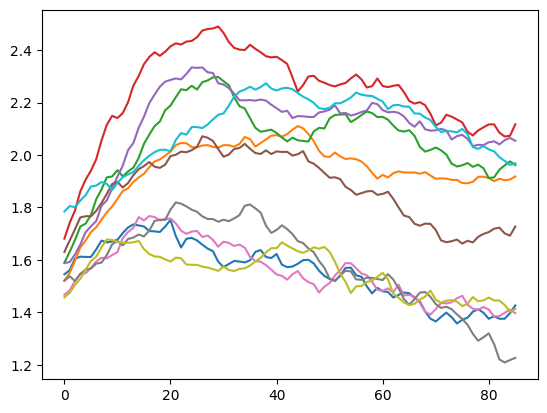

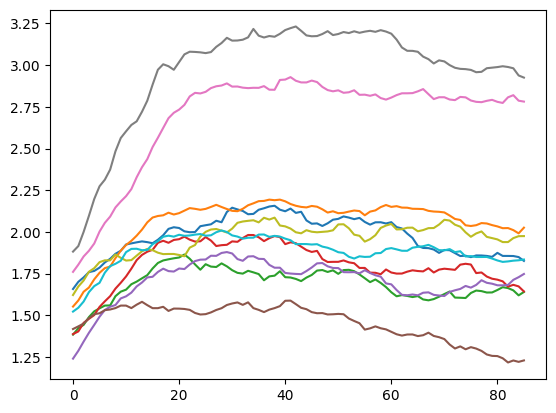

In [180]:
for i in range(10):
    plt.figure()
    plt.plot(gmt_smooth[i*10:(i+1)*10,:].T)
    plt.show()

In [ ]:
# trajectory without peak and decline: 
x_eoc = 1.8

### ref 
x     = np.arange(2015,2101,1)
x_gen = (np.array([2015,2100])-2015)
p     = np.polyfit(x_gen*0.08/(1+x_gen*0.08), 
                    [1,1.8],
                    deg = 1)
gmt_2 = p[0]*(x-2015)*0.075/(0.075*(x-2015)+1)+p[1]

### overshoot
p1    = np.polyfit([2015,2050,2085], 
                    [1,2.0,1],
                    deg = 2)
p2    = np.polyfit([2000,2050,2100], 
                    [1.8,2.0,1.8],
                    deg = 2)

gmt_3      = p1[0]*x**2+p1[1]*x+p1[2]
gmt_3[35:] = p2[0]*x[35:]**2+p2[1]*x[35:]+p2[2]

# compute impact for different temperatures: 
gmt_2_constructed = gmt_2+gmt_tmp[102,:]-gmt_smooth[102,:]
gmt_3_constructed = gmt_3+gmt_tmp[102,:]-gmt_smooth[102,:]

gmt_2_exc = (gmt_2_constructed[gmt_2_constructed>1.2]-1.2).sum()
gmt_2_uxc = -(gmt_2_constructed[gmt_2_constructed<1.2]-1.2).sum()
gmt_3_exc = (gmt_3_constructed[gmt_3_constructed>1.2]-1.2).sum()
gmt_3_uxc = -(gmt_3_constructed[gmt_3_constructed<1.2]-1.2).sum()


x_Ts      = np.arange(10,30.05,0.05)
impacts_2 = -(1-np.exp(gmt_2_exc*results_country_params[1]+gmt_2_exc*x_Ts*results_country_params[5]+gmt_2_uxc*results_country_params[2]+gmt_2_uxc*x_Ts*results_country_params[6]+x_eoc*results_country_params[3]))*100
impacts_3 = -(1-np.exp(gmt_3_exc*results_country_params[1]+gmt_3_exc*x_Ts*results_country_params[5]+gmt_3_uxc*results_country_params[2]+gmt_3_uxc*x_Ts*results_country_params[6]+x_eoc*results_country_params[3]))*100